In [13]:
from pathlib import Path
import requests
import rasterio as rio
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

from omnicloudmask import predict_from_array
import omnicloudmask

In [14]:
omnicloudmask.__version__

'1.5.0'

Go to https://www.maxar.com/open-data/ scroll to the bottom, select one of the captured events (from 2023 or late 2022) and click 'Learn more', on the new page select one of the scenes and click the corresponding 'QUAD KEY' button, from the new popup right click on the 'Multispectral Image' button and select copy url. Past that url below to download and run inference.


In [15]:
url = "https://maxar-opendata.s3.us-west-2.amazonaws.com/events/Emilia-Romagna-Italy-flooding-may23/ard/32/120000303231/2023-05-23/1050010033C95B00-ms.tif"
# url = "https://maxar-opendata.s3.us-west-2.amazonaws.com/events/tonga-volcano21/ard/01/300222121030/2022-01-18/1040010071C26C00-ms.tif"
# url = "https://maxar-opendata.s3.us-west-2.amazonaws.com/events/Kalehe-DRC-Flooding-5-8-23/ard/35/300000303201/2023-05-12/1040010084614200-ms.tif"
# url = "https://maxar-opendata.s3.us-west-2.amazonaws.com/events/New-Zealand-Flooding23/ard/60/213311212303/2023-02-08/10300100E23B4300-ms.tif"
# url = "https://maxar-opendata.s3.us-west-2.amazonaws.com/events/Hurricane-Ian-9-26-2022/ard/17/031331321021/2022-10-01/104001007C700900-ms.tif"

Download the Maxar image for inference


In [16]:
file_name = "_".join(url.split("/")[-3:])
scene_path = Path.cwd() / f"Maxar data/{file_name}"
scene_path.parent.mkdir(exist_ok=True, parents=True)

if not scene_path.exists():
    print(f"Downloading scene from {url} \nto {scene_path}")
    with requests.get(url, stream=True) as response:
        with open(scene_path, "wb") as f:
            pbar = tqdm(
                unit="B", unit_scale=True, total=int(response.headers["Content-Length"])
            )
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                pbar.update(8192)
    pbar.close()
else:
    print(f"Scene already exists: {scene_path}")

Scene already exists: /home/nick/Documents/Work code/OmniCloudMask/examples/Maxar data/120000303231_2023-05-23_1050010033C95B00-ms.tif


Maxar images are 50cm resolution so we will resample them to 10 m for inference


In [17]:
required_res = 10

Some Maxar MS images have 4 channels others have 8, we need to work out which type we have and extract the Red Green (Blue for visualisation) and NIR bands.


In [18]:
src = rio.open(scene_path)
channel_count = src.meta["count"]
if channel_count == 4:
    print("Found 4 channels, assuming RGBN")
    GRB_NIR_bands = [1, 2, 3, 4]
if channel_count == 8:
    print("Found all 8 channels")
    GRB_NIR_bands = [5, 3, 2, 8]

Found 4 channels, assuming RGBN


Open the RGB+NIR bands at the required resolution


In [19]:
res = src.res
RGBN_array = src.read(
    GRB_NIR_bands,
    out_shape=(
        4,
        int(src.height * res[0] / required_res),
        int(src.width * res[0] / required_res),
    ),
)

Separate the RGB bands for visualisation and the RG+NIR bands for inference.


In [20]:
RGB_array = RGBN_array[:3]
RGB_array = RGB_array.transpose(1, 2, 0)
RGN_array = RGBN_array[[0, 1, 3]]

Normalise the RGB channels and plot the image


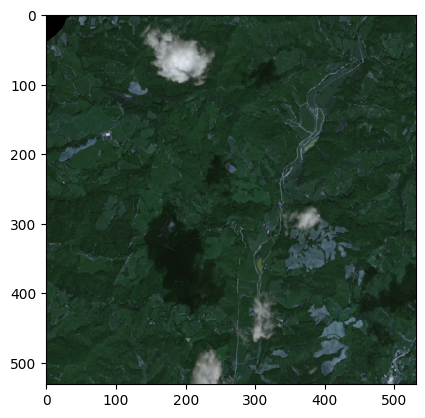

In [21]:
RGB_array_norm = np.power(RGB_array.astype("float32"), 0.5)
RGB_array_norm = RGB_array_norm - np.min(RGB_array_norm)
RGB_array_norm = RGB_array_norm / np.max(RGB_array_norm)

RGB_array_norm = np.clip(RGB_array_norm, 0, 1)
plt.imshow(RGB_array_norm)

Perform inference on the RG+NIR bands using the 'predict_from_array' function


In [26]:
mask = predict_from_array(RGN_array)

/home/nick/Documents/Work code/OmniCloudMask/omnicloudmask/cloud_mask.py:219: UserWarning: Patch size too large, reducing to 531 and 
            overlap to 265.
  patch_overlap, patch_size = check_patch_size(


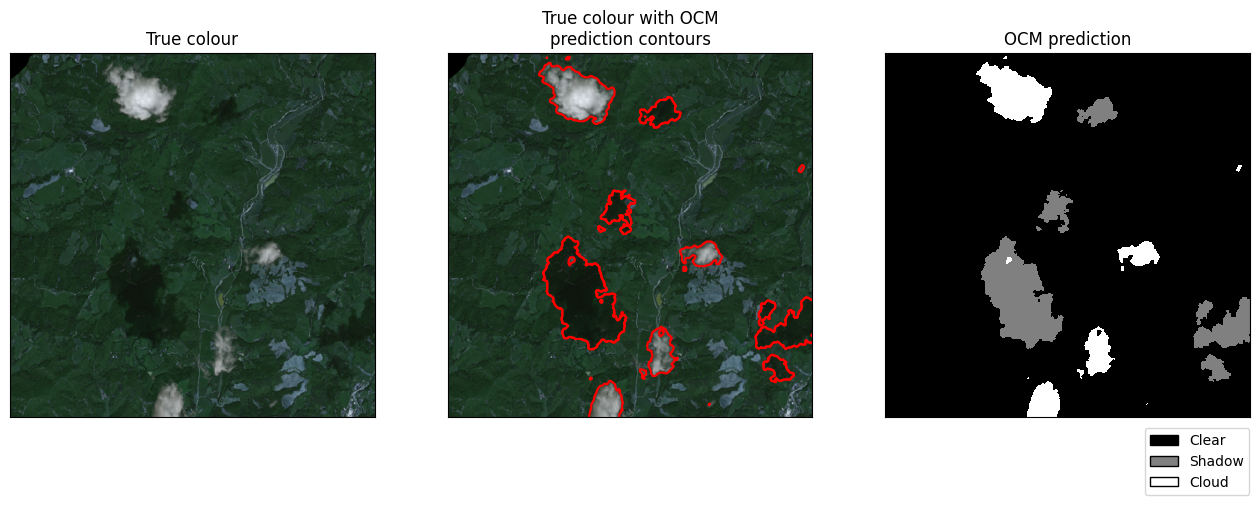

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
cmap = ListedColormap(["black", "white", "white", "grey"])

ax[0].imshow(RGB_array_norm)
ax[1].imshow(RGB_array_norm)
ax[1].contour(mask[0] > 0, colors="red", linewidths=1.5)
ax[1].contour(mask[0] == 3, colors="red", linewidths=1.5)
ax[2].imshow(mask[0], vmin=0, vmax=3, cmap=cmap, interpolation="nearest")

legend_labels = ["Clear", "Shadow", "Cloud"]
legend_colors = ["black", "grey", "white"]
patches = [
    mpatches.Patch(
        facecolor=legend_colors[i], edgecolor="black", label=legend_labels[i]
    )
    for i in range(3)
]
fig.legend(handles=patches, loc="lower right", bbox_to_anchor=(0.904, 0.05))

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

ax[0].set_title("True colour")
ax[1].set_title("True colour with OCM\nprediction contours")
ax[2].set_title("OCM prediction")

plt.show()